## Run if using Google Colab

In [ ]:
!pip install pyvis
!pip install geopy

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
%cd '/content/drive/MyDrive/Cours 3A/Projet 3A/Challenge Alstom - IA PAU'

## Imports

In [2]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import random
from itertools import chain, product
import geopy.distance
import numpy as np
from copy import deepcopy

##  (TODO) : Correcting stations information with another file

In [3]:
df_complete_network = pd.read_csv('data/pau_challenge/emplacement-des-gares-idf.csv', sep=';')
df_complete_network = df_complete_network[df_complete_network['mode'] == 'METRO']
df_complete_network = df_complete_network[['Geo Point', 'nom_ZdA', 'indice_lig']]
# df_complete_network['nom_ZdC'] = df_complete_network['nom_ZdC'].apply(unidecode)
df_complete_network.info()
df_complete_network.head()

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 76 to 1232
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Geo Point   405 non-null    object
 1   nom_ZdA     405 non-null    object
 2   indice_lig  405 non-null    object
dtypes: object(3)
memory usage: 12.7+ KB


,Geo Point,nom_ZdA,indice_lig
76,"48.86251523497548, 2.345785860039181",Châtelet les Halles,4
101,"48.834292980473194, 2.33285230996089",Denfert-Rochereau,6
102,"48.87514981972761, 2.295904904713175",Charles-de-Gaulle Étoile,1
103,"48.884896255150515, 2.2977243464801775",Péreire Levallois,3
104,"48.85316798489062, 2.343285978923924",Saint-Michel Notre-Dame,4


In [89]:
replace_dict = {
    "Mouton Duvernet" : "Mouton-Duvernet",
    "Porte de La Chapelle" : "Porte de la Chapelle",
    "Bobigny-Pantin - Raymond Queneau" : "Bobigny Pantin Raymond Queneau",
    "Le Kremlin - Bicêtre" : "Le Kremlin-Bicêtre",
    "Saint-Paul (Le Marais)" : "Saint-Paul",
    "Bagneux - Lucie Aubrac" : "Bagneux Lucie Aubrac",
    "Michel-Ange - Auteuil" : "Michel-Ange Auteuil",
    "Asnières - Gennevilliers Les Courtilles" : "Les Courtilles",
    "Malakoff Rue Étienne Dolet" : "Malakoff Rue Étienne-Dolet",
    "Ledru Rollin" : "Ledru-Rollin",
    "Maisons-Alfort - Stade" : "Maisons-Alfort Stade",
    "Alma - Marceau" : "Alma Marceau",
    

    "Saint-Denis - Université" : "Saint-Denis Université",
    "Cour Saint-Emilion" : "Cour Saint-Émilion",
    "Bonne Nouvelle" : "Bonne-Nouvelle",
    "La Motte Picquet - Grenelle" : "La Motte-Picquet Grenelle",
    "Pont de Levallois - Bécon" : "Pont de Levallois Bécon",
    "Bréguet-Sabin" : "Bréguet Sabin",
    "Chardon Lagache" : "Chardon-Lagache",
    "Michel-Ange - Molitor" : "Michel-Ange Molitor",
    "Montparnasse Bienvenue" : "Montparnasse Bienvenüe",
    "Avenue Émile Zola" : "Avenue Émile-Zola",
    "Paul Vaillant Couturier" : "Villejuif Paul Vaillant-Couturier",
    "Porte de La Villette" : "Porte de la Villette",
    "Quatre Septembre" : "Quatre-Septembre",
    "Châtelet les Halles" : "Les Halles",
    "Campo Formio" : "Campo-Formio",


    "La Courneuve - 8 Mai 1945" : "La Courneuve 8 Mai 1945",
    "Boulogne Pont de Saint-Cloud - Albert Kahn" : "Boulogne Pont de Saint-Cloud",
    "Assemblée Nationale" : "Assemblée nationale",
    "Chaussée d'Antin - La Fayette" : "Chaussée d'Antin La Fayette",
    "Malakoff - Plateau De Vanves" : "Malakoff Plateau de Vanves",
    "Pré Saint-Gervais" : "Pré-Saint-Gervais",
    "La Tour Maubourg" : "La Tour-Maubourg",


    "Charles-de-Gaulle Étoile" :  "Charles de Gaulle Étoile",
    "Péreire Levallois" : "Pereire",
    "Pont Marie (Cité des Arts)" : "Pont Marie",
    "Palais Royal - Musée Du Louvre" : "Palais-Royal Musée du Louvre",


    "Richard Lenoir" : "Richard-Lenoir",
    "Javel" : "Javel André Citroën",
    "Saint-Michel Notre-Dame" : "Saint-Michel",
    
    
    "Bibliothèque François Mitterrand" : "Bibliothèque François-Mitterrand",
    "École Vétérinaire de Maisons-Alfort" : "École vétérinaire de Maisons-Alfort",
    "Châtillon-Montrouge" : "Châtillon Montrouge",
    "Pont Neuf" : "Pont-Neuf",
    "Porte d'Orléans (Général Leclerc)" : "Porte d'Orléans",
    "Saint-François Xavier" : "Saint-François-Xavier"
    
}

In [142]:
df_complete_network['nom_ZdA'] = df_complete_network['nom_ZdA'].replace(replace_dict)
df_complete_network['indice_lig'] = df_complete_network['indice_lig'].str.replace('7b', '7bis')

In [143]:
print(df_complete_network['indice_lig'].unique())
df_complete_network[df_complete_network['indice_lig'] == '7bis']

['4' '6' '1' '3' '10' '5' '11' '8' '13' '7bis' '12' '9' '7' '2' '14'
 '3bis']


,Geo Point,nom_ZdA,indice_lig
115,"48.87851411402383, 2.3816145119289653",Buttes Chaumont,7bis
134,"48.87694984811022, 2.3929839648173936",Place des Fêtes,7bis
162,"48.880271957029535, 2.3984681722681724",Pré-Saint-Gervais,7bis
297,"48.881192119070995, 2.364378741179748",Louis Blanc,7bis
493,"48.880667463456206, 2.374495966260425",Bolivar,7bis
864,"48.88246524557207, 2.370157961739611",Jaurès,7bis
986,"48.87949310793359, 2.3885668704791967",Botzaris,7bis
992,"48.88181610818685, 2.394012398359364",Danube,7bis


In [144]:
df_complete_network['Geo Point'].isna().sum()

0

## Network plan

In [2]:
df_network_plan = pd.read_csv('data/pau_challenge/plan du métro.csv')
# df_network_plan['de Station'] = df_network_plan['de Station'].str.replace(' - ',' ')
df_network_plan.info()
df_network_plan.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   de Ligne      1010 non-null   object
 1   de Station    1010 non-null   object
 2   vers Ligne    1010 non-null   object
 3   vers Station  1010 non-null   object
dtypes: object(4)
memory usage: 31.7+ KB


,de Ligne,de Station,vers Ligne,vers Station
0,1,Charles de Gaulle - Étoile,2,Charles de Gaulle - Étoile
1,1,Charles de Gaulle - Étoile,6,Charles de Gaulle - Étoile
2,1,Franklin D. Roosevelt,9,Franklin D. Roosevelt
3,1,Champs-Élysées - Clemenceau,13,Champs-Élysées - Clemenceau
4,1,Concorde,8,Concorde


In [3]:
#removing inter-station where target corresponds to a tramway station
df_network_plan = df_network_plan[~df_network_plan['vers Ligne'].isin(['\xa01', '\xa07', '\xa02', '\xa08', '\xa06'])]

In [153]:
print(set(df_network_plan['vers Ligne'].unique()) == set(df_network_plan['de Ligne'].unique()))

True


In [154]:
print(set(df_network_plan['vers Station'].unique()) == set(df_network_plan['de Station'].unique()))

True


In [4]:
df_position = pd.read_csv('data/pau_challenge/position gps des stations de métro.csv')
df_position.info()
print(df_position.head())

#Removing Malsesherbes RER Station
df_position = df_position.drop([151])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Station  386 non-null    object
 1   GPS      386 non-null    object
dtypes: object(2)
memory usage: 6.2+ KB
      Station                                    GPS
0   Boucicaut   48.84109405724891, 2.287945766487378
1      Bourse  48.86865415183625, 2.3413760511435733
2  Bir-Hakeim  48.85394260621378, 2.2893345327788075
3   Argentine  48.87533684211653, 2.2901275088247015
4   Daumesnil  48.83954964556868, 2.3957032894363937


In [156]:
network_stations = {station : {} for station in df_network_plan['de Station'].unique()}
reverse_network_stations = {}

# unique (station, line) couples that we're using as nodes in our graph
df_nodes = df_network_plan.groupby(['de Station','de Ligne']).size().reset_index().rename(columns={0:'count'})

count=0
for node in df_nodes.values:
  network_stations[node[0]].update({node[1] : count})
  reverse_network_stations.update({count : {'title' : node[0], 'group' :node[1]}})
  count+=1

In [157]:
unspecified_loc_nodes = []
for station, station_lines in network_stations.items():
  df_coords = df_position[df_position['Station'] == station]
  if not df_coords.empty:
    complete_gps = []
    if len(station_lines.values()) - len(df_coords['GPS'].values) > 0:
      for _ in range(len(station_lines.values()) - len(df_coords['GPS'].values)):
        complete_gps.append(random.choice(df_coords['GPS'].values))

    for coord, node_station in zip([*df_coords['GPS'].values, *complete_gps], station_lines.values()):
      lat, lon = coord.split(', ')
      lat, lon = float(lat), float(lon)
      reverse_network_stations[node_station].update({'lon':lon, 'lat':lat})
  else:
    unspecified_loc_nodes = [*unspecified_loc_nodes, *station_lines.values()]

In [158]:
edges = []
for edge in df_network_plan.values:
  edges.append((network_stations[edge[1]][edge[0]], network_stations[edge[3]][edge[2]]))

In [159]:
def get_node_neighbors(G, node, distance=1):
  if distance == 1:
    neighbors = list(G.neighbors(node))
    return neighbors
  else:
    neighbors = list(G.neighbors(node))
    total_neighbors = [neighbors.copy()]
    for neighbor in neighbors:
      total_neighbors.append(get_node_neighbors(G, neighbor, distance-1))
    total_neighbors = list(chain(*total_neighbors))
    return list(set(total_neighbors))

In [160]:
network_graph = nx.DiGraph()
network_graph.add_edges_from(edges)
nx.set_node_attributes(network_graph, reverse_network_stations)

In [161]:
for station, station_lines in network_stations.items():
    station_nodes = station_lines.values()
    if len(station_nodes)>1:
        for edge in product(station_nodes, repeat=2):
            if not network_graph.has_edge(*edge) and edge[0] != edge[1]:
                network_graph.add_edge(*edge)

In [162]:
min_dist = 3
max_dist = 3
unspecified_loc_nodes_pos = {}
for node_station in unspecified_loc_nodes:
  mean_lat, mean_lon = [], []
  for dist in range(min_dist,max_dist+1):
    for neighbor in get_node_neighbors(network_graph, node_station, distance=dist):

      lon = reverse_network_stations[neighbor].get('lon')
      lat = reverse_network_stations[neighbor].get('lat')
      if lon is not None and lat is not None:
        mean_lat.append(lat)
        mean_lon.append(lon)

    if len(mean_lat) > 0 and len(mean_lon) > 0:
      unspecified_loc_nodes_pos.update({node_station : {'lon' : sum(mean_lon)/len(mean_lon), 'lat': sum(mean_lat)/len(mean_lat)}})
      break
    else:
      print(node_station)
      continue
nx.set_node_attributes(network_graph, unspecified_loc_nodes_pos)

## Adding edge weight based on distance between stations

In [163]:
for edge in network_graph.edges:
  start_node = network_graph.nodes[edge[0]]
  end_node = network_graph.nodes[edge[1]]
  distance = geopy.distance.geodesic((start_node['lat'], start_node['lon']), (end_node['lat'], end_node['lon'])).km
  network_graph.edges[edge]['inv_dist_km'] = 1/distance if distance != 0 else 1.0

## Network visualization

### With `pyvis`



In [132]:
net_viz = Network(directed=True)
net_viz.from_nx(network_graph)
net_viz.save_graph('viz/network_graph_test.html')

### Using `networkx` API

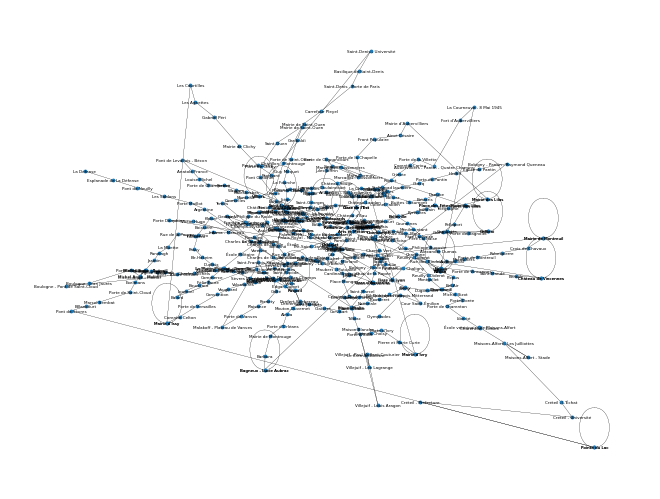

In [164]:
pos = {node_idx : (node['lon'], node['lat']) for node_idx, node in network_graph.nodes.items()}

nx.draw(network_graph, node_size=3, width=0.1, arrowsize=0.2, pos=pos, labels=nx.get_node_attributes(network_graph, 'title'), font_size=3)
#

## Flow for each path

In [133]:
df_flow = pd.read_csv('data/pau_challenge/passagers.csv')
df_flow.info()
df_flow.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93942 entries, 0 to 93941
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   de      93942 non-null  object
 1   vers    93942 non-null  object
 2   nombre  93942 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


,de,vers,nombre
0,La Défense,Esplanade de La Défense,7
1,La Défense,Pont de Neuilly,5
2,La Défense,Les Sablons,6
3,La Défense,Porte Maillot,6
4,La Défense,Argentine,5


In [ ]:
def get_best_path(network_stations, start_station, end_station):
  lb_path_weight = 0
  best_path = None
  for start_node in network_stations[start_station].values():
    for end_node in network_stations[end_station].values():
      try:
        current_path = nx.dijkstra_path(network_graph, start_node, end_node, weight='inv_dist_km')
        current_path_weight = sum([network_graph.edges[edge]['inv_dist_km'] for edge in zip(current_path[:-1], current_path[1:])])
        if current_path_weight > lb_path_weight:
          lb_path_weight = current_path_weight
          best_path = current_path
      except nx.NetworkXNoPath:
        print(f"Could not find a path between {reverse_network_stations[start_node]['title']} (line {reverse_network_stations[start_node]['group']}) \
              and {reverse_network_stations[end_node]['title']} (line {reverse_network_stations[end_node]['group']})")
  return best_path

path_idx = np.random.randint(0, len(df_flow))
test_path = df_flow.iloc[path_idx]
print(test_path)
start_station = test_path['de']
end_station = test_path['vers']
flow = test_path['nombre']

best_path = get_best_path(network_stations, start_station, end_station)
print(" ->\n".join([f'{reverse_network_stations[node]["title"]} ({reverse_network_stations[node]["group"]})' for node in best_path]))

de                 Hôtel de Ville
vers      Marcadet - Poissonniers
nombre                          2
Name: 4664, dtype: object
Hôtel de Ville (1) ->
Châtelet (1) ->
Châtelet (7) ->
Châtelet (11) ->
Hôtel de Ville (11) ->
Rambuteau (11) ->
Arts et Métiers (11) ->
République (11) ->
République (3) ->
Parmentier (3) ->
Rue Saint-Maur (3) ->
Père Lachaise (3) ->
Gambetta (3) ->
Porte de Bagnolet (3) ->
Gallieni (3) ->
Gallieni (3bis)


In [135]:
def get_nodes_traffic(network_graph, df_flow):
  nodes_traffic = {node_idx : {'traffic' : 0} for node_idx in network_graph.nodes}
  for path_idx in range(len(df_flow)):
    path = df_flow.iloc[path_idx]
    start_station = path['de']
    end_station = path['vers']
    flow = path['nombre']
    best_path = get_best_path(network_stations, start_station, end_station)
    if best_path is not None:
      for node in best_path:
        nodes_traffic[node]['traffic'] += flow
  return nodes_traffic

nodes_traffic = get_nodes_traffic(network_graph, df_flow)

In [136]:
total_trafic = sum([node['traffic'] for node in nodes_traffic.values()])
print(total_trafic)
normalized_nodes_traffic = {node_idx : {'traffic' : node['traffic']/total_trafic} for node_idx, node in nodes_traffic.items()}

7710100


In [137]:
nx.set_node_attributes(network_graph, normalized_nodes_traffic)

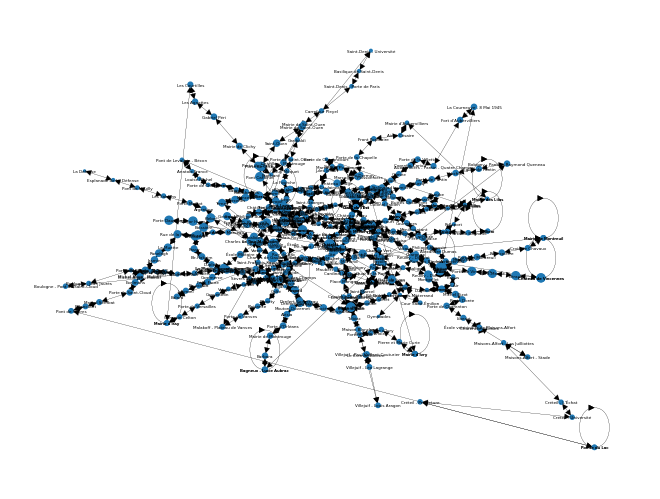

In [138]:
node_size = [5000*node['traffic'] for node in network_graph.nodes.values()]
pos = {node_idx : (node['lon'], node['lat']) for node_idx, node in network_graph.nodes.items()}

nx.draw(network_graph, node_size=node_size, width=0.1, pos=pos, labels=nx.get_node_attributes(network_graph, 'title'), font_size=3)

## Creating degraded network from initial

In [139]:
def get_degraded_network(network_graph: nx.Graph, num_delete=10):
    degraded_graph = network_graph.copy()
    graph_edges = deepcopy(list(network_graph.edges))
    for i in range(num_delete):
        is_deletable = False
        while not is_deletable:
            deleted_edge = random.choice(graph_edges)
            # print(deleted_edge)
            simple_paths = [simple_path for simple_path in nx.all_simple_paths(degraded_graph, deleted_edge[0], deleted_edge[1], cutoff=5)]
            # print(len(simple_paths))
            if len(simple_paths) > 1:
                degraded_graph.remove_edge(deleted_edge[0], deleted_edge[1])
                graph_edges.remove(deleted_edge)
                is_deletable = True
                print("Deleted", deleted_edge)
        
    return degraded_graph

In [140]:
degraded_network = get_degraded_network(network_graph)
print(len(network_graph.edges))
print(len(degraded_network.edges))

Deleted (85, 84)
Deleted (351, 354)
Deleted (378, 9)
Deleted (339, 342)
Deleted (354, 353)
Deleted (155, 154)
Deleted (124, 122)
Deleted (144, 65)
Deleted (8, 338)
Deleted (322, 103)
1054
1044
